### SV calling from pairwise cigar strings - chr 8 initial testing

This notebook generates plots for SVs derived from centrolign pairwise cigar strings. 

In [1]:
# Import statements
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
## Read in input data 

# csv formatted as clade, path_to_SV_beds 
input_csv="/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr8/test/plotting_script_samples.csv"

# prefix for output plots
plot_prefix="/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr8/test/plots/"

# pairwise distance file 
pairwise_dist="/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/chr8_r2_QC_v2_centrolign_pairwise_distance.csv"

In [3]:
### This function reads in the SV bed files into a pandas DF for a given clade. 

def read_sv_bed_files(clade, bed_folder):
    """
    Read all .bed files in a folder and add a 'clade' column to the data frame
    Each bed file has columns:
        sample1, start, end, sample2, start, end, type, diff
    """
    all_beds = []
    bed_files = [f for f in os.listdir(bed_folder) if f.endswith(".bed")]
    print(f"Found {len(bed_files)} SV bed files for clade '{clade}'")

    # Ensure folder exists
    if not os.path.isdir(bed_folder):
        raise FileNotFoundError("Folder not found for clade '{}': {}".format(clade, bed_folder))

    for filename in os.listdir(bed_folder):
        if filename.endswith(".bed"):
            bed_path = os.path.join(bed_folder, filename)
            try:
                df = pd.read_csv(
                    bed_path,
                    sep="\t",
                    header=None,
                    names=["sample1", "start1", "end1", "sample2", "start2", "end2", "type", "diff"]
                )
                df["clade"] = clade
                df["source_file"] = filename  # optional, helps track origin
                df["length"] = np.where(
                    df["type"] == "I",
                    df["end2"] - df["start2"],  # insertion → use sample2 coords
                    df["end1"] - df["start1"]  # otherwise (deletion) → sample1 coords
                )
                all_beds.append(df)
            except Exception as e:
                print("Warning: Could not read {}: {}".format(bed_path, e))

    if all_beds:
        return pd.concat(all_beds, ignore_index=True)
    else:
        print("Warning: No .bed files found in {} for clade '{}'".format(bed_folder, clade))
        return pd.DataFrame(columns=["sample1", "start1", "end1", "sample2", "start2", "end2", "type", "diff", "clade", "source_file"])


In [4]:
### For all clades in provided input csv, read SVs into dataframe and merge 

clade_info = pd.read_csv(input_csv)
if not {"clade", "path_to_SV_beds"}.issubset(clade_info.columns):
    raise ValueError("Input CSV must contain columns: 'clade' and 'path_to_SV_beds'")

all_data = []

for _, row in clade_info.iterrows():
    clade = str(row["clade"])
    bed_folder = str(row["path_to_SV_beds"])
    df = read_sv_bed_files(clade, bed_folder)
    if not df.empty:
        all_data.append(df)

if all_data:
    merged_df = pd.concat(all_data, ignore_index=True)

    #print("=== Head of merged DataFrame ===")
    #(merged_df.head(), "\n")

    # Print count of rows per clade
    print("=== Record count per clade ===")
    print(merged_df["clade"].value_counts())

Found 15 SV bed files for clade 'subgroup_0_Clade_1'
Found 6786 SV bed files for clade 'subgroup_0_Clade_2'
Found 10 SV bed files for clade 'subgroup_0_Clade_3'
Found 406 SV bed files for clade 'subgroup_0_Clade_4'
Found 1 SV bed files for clade 'subgroup_0_Clade_5'
Found 3 SV bed files for clade 'subgroup_0_Clade_6'
Found 210 SV bed files for clade 'subgroup_0_Clade_7'
Found 1 SV bed files for clade 'subgroup_0_Clade_8'
Found 12403 SV bed files for clade 'subgroup1'
=== Record count per clade ===
clade
subgroup1             4718021
subgroup_0_Clade_2    2263877
subgroup_0_Clade_4      89557
subgroup_0_Clade_7      31576
subgroup_0_Clade_1       3011
subgroup_0_Clade_3       1565
subgroup_0_Clade_6        549
subgroup_0_Clade_5        113
subgroup_0_Clade_8         78
Name: count, dtype: int64


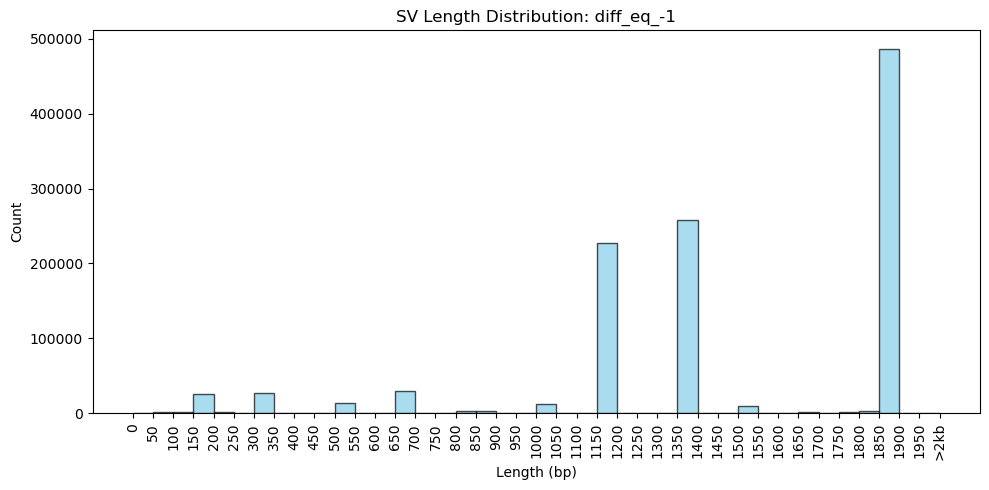

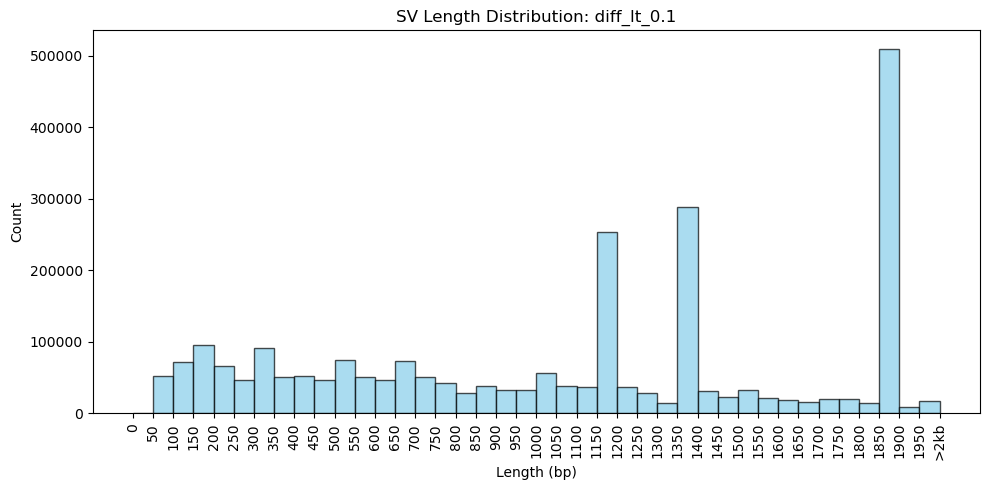

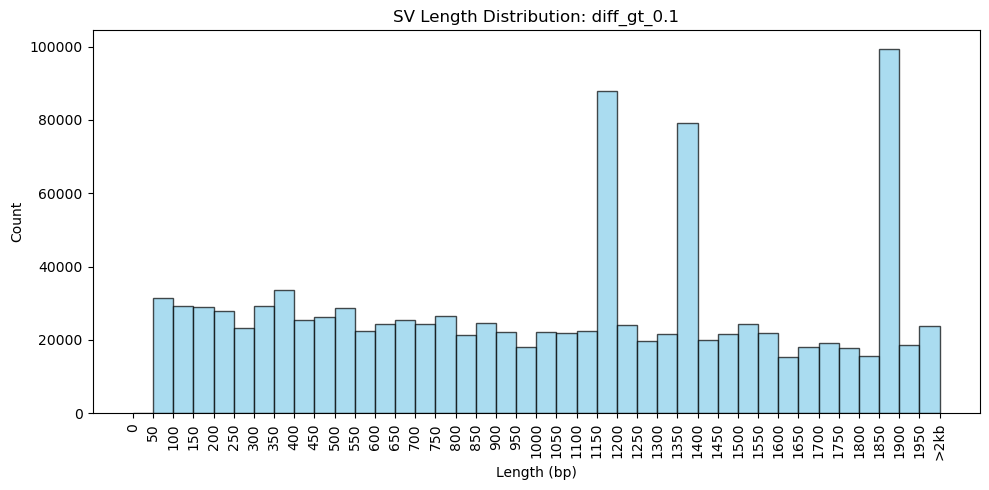

In [5]:
### SV length distributions for all SVs. Has options to zoom into specific length sizes

def plot_length_distributions(df, output_prefix, min_sv=None, max_sv=None, bin_size=1000, max_bin=50000
):
    """
    Generate SV length histograms with configurable filtering and binning.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns: 'type', 'diff', and 'length'.
    output_prefix : str
        File path prefix for saving plots.
    min_sv : int, optional
        Minimum SV length (bp) to include in the plot. Default = None (no lower limit).
    max_sv : int, optional
        Maximum SV length (bp) to include in the plot. Default = None (no upper limit).
    bin_size : int, optional
        Size of each histogram bin in base pairs. Default = 1000.
    max_bin : int, optional
        Maximum bin cutoff; all SVs >= max_bin are grouped into the final bin. Default = 50,000 bp.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    # Ensure directory exists
    out_dir = os.path.dirname(output_prefix)
    if out_dir and not os.path.exists(out_dir):
        os.makedirs(out_dir)

    # Define filter conditions
    conditions = [
        ("diff_eq_-1",  (df["diff"] == -1)),
        ("diff_lt_0.1",  (df["diff"] < 0.1)),
        ("diff_gt_0.1",  (df["diff"] > 0.1))
    ]

    for label, cond in conditions:
        subset = df[cond].copy()

        # Apply SV size filtering if requested
        if min_sv is not None:
            subset = subset[subset["length"] >= min_sv]
        if max_sv is not None:
            subset = subset[subset["length"] <= max_sv]

        if subset.empty:
            print(f"No SVs found for {label} within given size range.")
            continue

        # Cap lengths at max_bin for plotting/counting
        lengths = subset["length"].copy()
        lengths_capped = np.where(lengths >= max_bin, max_bin, lengths)

        # Define bins
        bin_start = min_sv if min_sv is not None else 0
        bins = np.arange(bin_start, max_bin + bin_size, bin_size)
        counts, bin_edges = np.histogram(lengths_capped, bins=bins)

        # Count SVs >= max_bin separately and add to final bin
        overflow_count = (lengths >= max_bin).sum()
        counts[-1] += overflow_count

        # Print bin counts
        # print(f"\n=== {label} ===")
        # print("Bin range (bp) | Count")
        # for i in range(len(counts) - 1):
        #     print(f"{int(bin_edges[i])}-{int(bin_edges[i+1]-1)} | {counts[i]}")
        # print(f">={max_bin}| {overflow_count}")

        # Plot histogram
        plt.figure(figsize=(10, 5))
        x_pos = bin_edges[:-1]

        plt.bar(
            x_pos,
            counts,
            width=bin_size,
            align='edge',
            color="skyblue",
            edgecolor="black",
            alpha=0.7
        )

        # Label x-axis
        x_labels = [str(int(edge)) for edge in bin_edges[:-1]] + [f">{max_bin/1000:.0f}kb"]
        plt.xticks(list(x_pos) + [max_bin], x_labels, rotation=90)

        plt.title(f"SV Length Distribution: {label}")
        plt.xlabel("Length (bp)")
        plt.ylabel("Count")
        plt.tight_layout()

        output_file = f"{output_prefix}_{label}.png"
        #plt.savefig(output_file)
        #plt.close()
        plt.show()
        #print(f"Saved plot: {output_file}")


#plot_length_distributions(merged_df, plot_prefix+"all_SVs")
#plot_length_distributions(merged_df, plot_prefix+"SVs_1kb_2kb",min_sv=1000,max_sv=2000,bin_size=20,max_bin=2000)
plot_length_distributions(merged_df, plot_prefix+"SVs_1150_2kb",min_sv=0,max_sv=2000,bin_size=50,max_bin=2000)

Add pairwise distances to SV dataframe

In [5]:
# read in pairwise distances 
column_names = ['sample1', 'sample2', 'pairwise_dist']
dist_df = pd.read_csv(pairwise_dist,header=None,names=column_names)  # sample1, sample2, dist
dist_df.head()

# Make sure both dataframes are order-independent for sample pairs
df_dist_sorted = dist_df.copy()
df_dist_sorted[['sample1', 'sample2']] = np.sort(df_dist_sorted[['sample1', 'sample2']], axis=1)

df_sv_sorted = merged_df.copy()
df_sv_sorted[['sample1', 'sample2']] = np.sort(df_sv_sorted[['sample1', 'sample2']], axis=1)

# Merge
df_sv_sorted = df_sv_sorted.merge(df_dist_sorted, on=['sample1', 'sample2'], how='left')

df_sv_sorted.head()

,sample1,start1,end1,sample2,start2,end2,type,diff,clade,source_file,length,pairwise_dist
0,HG00097.2,83046,83047,HG00741.1,83046,86783,I,-1.0,subgroup_0_Clade_1,HG00097.2_HG00741.1.bed,3737,0.188966
1,HG00097.2,160805,160806,HG00741.1,164542,188832,I,-1.0,subgroup_0_Clade_1,HG00097.2_HG00741.1.bed,24290,0.188966
2,HG00097.2,241298,241299,HG00741.1,269325,273060,I,-1.0,subgroup_0_Clade_1,HG00097.2_HG00741.1.bed,3735,0.188966
3,HG00097.2,262735,266473,HG00741.1,294497,294498,D,-1.0,subgroup_0_Clade_1,HG00097.2_HG00741.1.bed,3738,0.188966
4,HG00097.2,346761,346762,HG00741.1,374785,381752,I,-1.0,subgroup_0_Clade_1,HG00097.2_HG00741.1.bed,6967,0.188966


<Figure size 800x600 with 0 Axes>

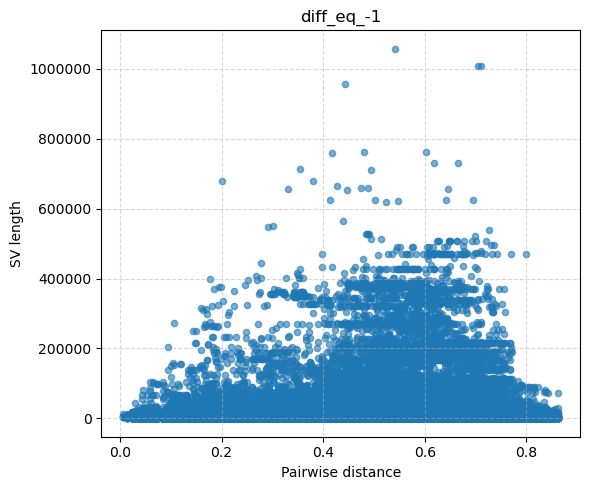

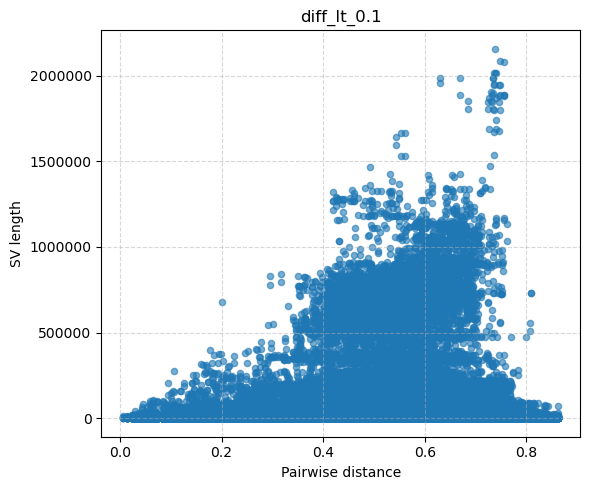

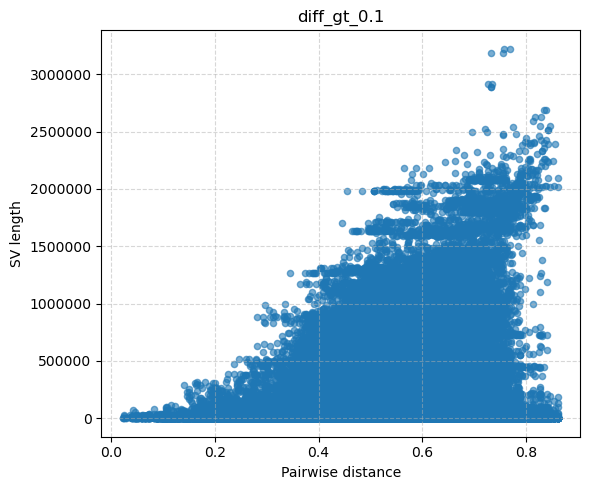

In [7]:
### Plot SV lengths vs pairwise distance for each condition 
from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(8, 6))

conditions = [
        ("diff_eq_-1",  (df_sv_sorted["diff"] == -1)),
        ("diff_lt_0.1",  (df_sv_sorted["diff"] < 0.1)),
        ("diff_gt_0.1",  (df_sv_sorted["diff"] > 0.1)),
]
for label, cond in conditions:
    subset = df_sv_sorted[cond].copy()

    plt.figure(figsize=(6, 5))
    plt.scatter(subset["pairwise_dist"], subset["length"], alpha=0.6, s=20)
    
    plt.xlabel("Pairwise distance")
    plt.ylabel("SV length")
    plt.title(label)
    plt.grid(True, linestyle="--", alpha=0.5)
    yfmt = ScalarFormatter(useOffset=False)
    yfmt.set_scientific(False)
    plt.gca().yaxis.set_major_formatter(yfmt)

    plt.tight_layout()
    plt.show()


     sample1  start1   end1    sample2  start2   end2 type  diff      clade  \
0  HG01252.1   30968  33325  HG04115.2   30968  30969    D   0.0  subgroup1   
1  HG01252.1   33325  33326  HG04115.2   30968  33325    I   0.0  subgroup1   
2  HG01252.1   42339  45459  HG04115.2   42336  42337    D   0.0  subgroup1   
3  HG01252.1   45459  45460  HG04115.2   42336  45456    I   0.0  subgroup1   
4  HG01252.1   46681  47102  HG04115.2   46678  46679    D   0.0  subgroup1   

               source_file  length  
0  HG01252.1_HG04115.2.bed    2357  
1  HG01252.1_HG04115.2.bed    2357  
2  HG01252.1_HG04115.2.bed    3120  
3  HG01252.1_HG04115.2.bed    3120  
4  HG01252.1_HG04115.2.bed     421  


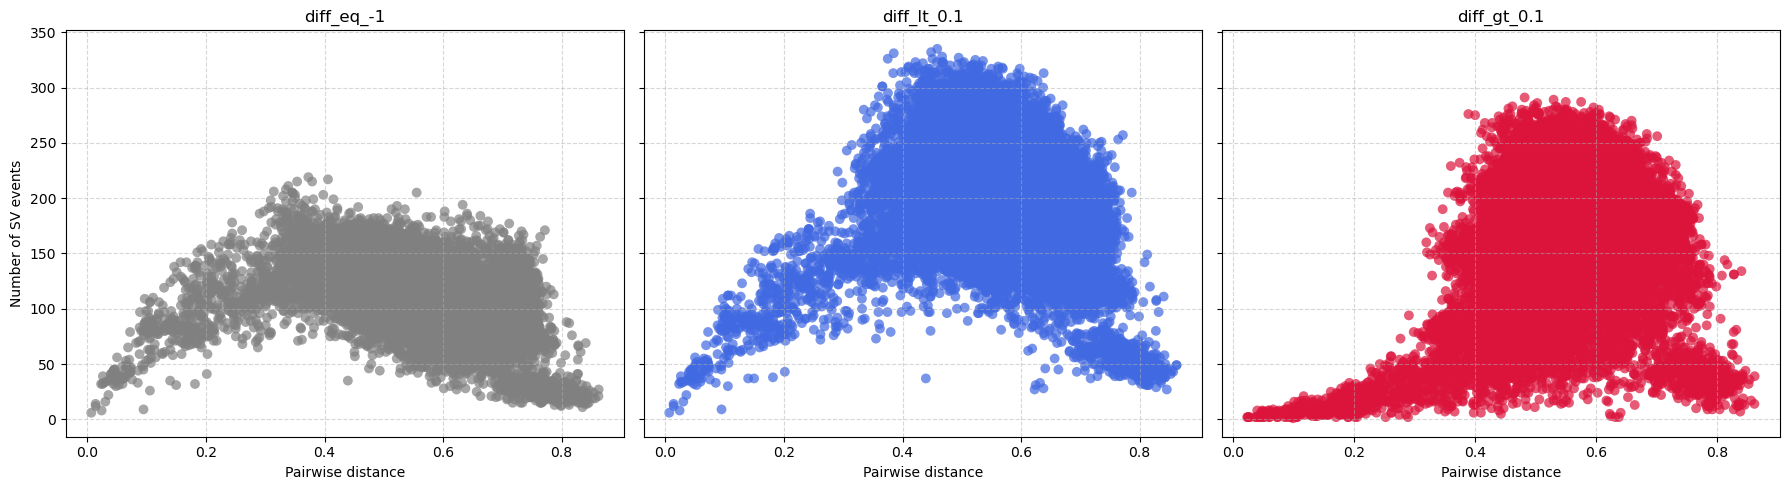

In [ ]:
conditions = [
    ("diff_eq_-1",  (df_sv_sorted["diff"] == -1)),
    ("diff_lt_0.1", (df_sv_sorted["diff"] < 0.1)),
    ("diff_gt_0.1", (df_sv_sorted["diff"] > 0.1))
]

colors = {
    "diff_eq_-1": "gray",
    "diff_lt_0.1": "royalblue",
    "diff_gt_0.1": "crimson"
}

# Create a sample_pair identifier

df_sv_sorted["sample_pair"] = df_sv_sorted["sample1"] + "_" + df_sv_sorted["sample2"]
print(df.head())
# Function to aggregate counts for a given condition
def aggregate_counts(df_sv_sorted, condition_mask):
    subset = df_sv_sorted[condition_mask]
    agg = subset.groupby("sample_pair").agg(
        sv_count=("type", "count"),
        pairwise_dist=("pairwise_dist", "first")  # same for all rows in the pair
    ).reset_index()
    return agg

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, (label, condition) in enumerate(conditions):
    agg = aggregate_counts(df_sv_sorted, condition)
    
    axes[i].scatter(
        agg["pairwise_dist"], agg["sv_count"],
        color=colors[label], alpha=0.7, s=50, edgecolor="none"
    )
    axes[i].set_title(label)
    axes[i].set_xlabel("Pairwise distance")
    axes[i].grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Number of SV events")

plt.tight_layout()
plt.show()

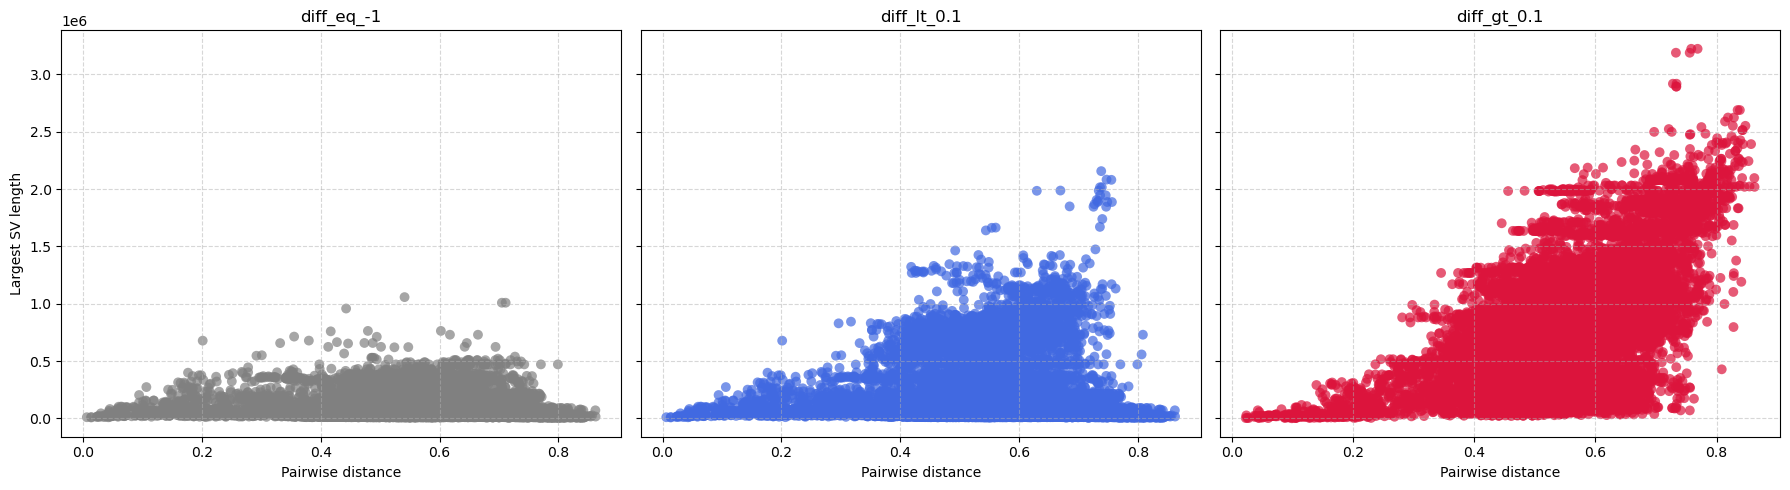

In [7]:
# Create a sample_pair identifier
df_sv_sorted["sample_pair"] = df_sv_sorted["sample1"] + "_" + df_sv_sorted["sample2"]

# Conditions
conditions = [
    ("diff_eq_-1",  (df_sv_sorted["diff"] == -1)),
    ("diff_lt_0.1", (df_sv_sorted["diff"] < 0.1)),
    ("diff_gt_0.1", (df_sv_sorted["diff"] > 0.1))
]

colors = {
    "diff_eq_-1": "gray",
    "diff_lt_0.1": "royalblue",
    "diff_gt_0.1": "crimson"
}

# ---------------------------------------------------------
# Function to extract the *largest SV per sample pair*
# ---------------------------------------------------------
def aggregate_max_sv(df, condition_mask):
    subset = df[condition_mask].copy()

    # Sort subset by length descending and keep only the largest SV per sample_pair
    subset = (
        subset.sort_values("length", ascending=False)
              .groupby("sample_pair", as_index=False)
              .first()
    )
    
    # Keep only fields we want to plot
    return subset[["sample_pair", "pairwise_dist", "length"]]


# ---------------------------------------------------------
# Plotting
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, (label, condition_mask) in enumerate(conditions):
    agg = aggregate_max_sv(df_sv_sorted, condition_mask)
    
    axes[i].scatter(
        agg["pairwise_dist"], 
        agg["length"],
        color=colors[label],
        alpha=0.7,
        s=50,
        edgecolor="none"
    )
    
    axes[i].set_title(label)
    axes[i].set_xlabel("Pairwise distance")
    axes[i].grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Largest SV length")

plt.tight_layout()
plt.show()


/data/tmp/ipykernel_872037/1227486815.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_872037/1227486815.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_872037/1227486815.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_872037/1227486815.py:45: FutureWarning: The default

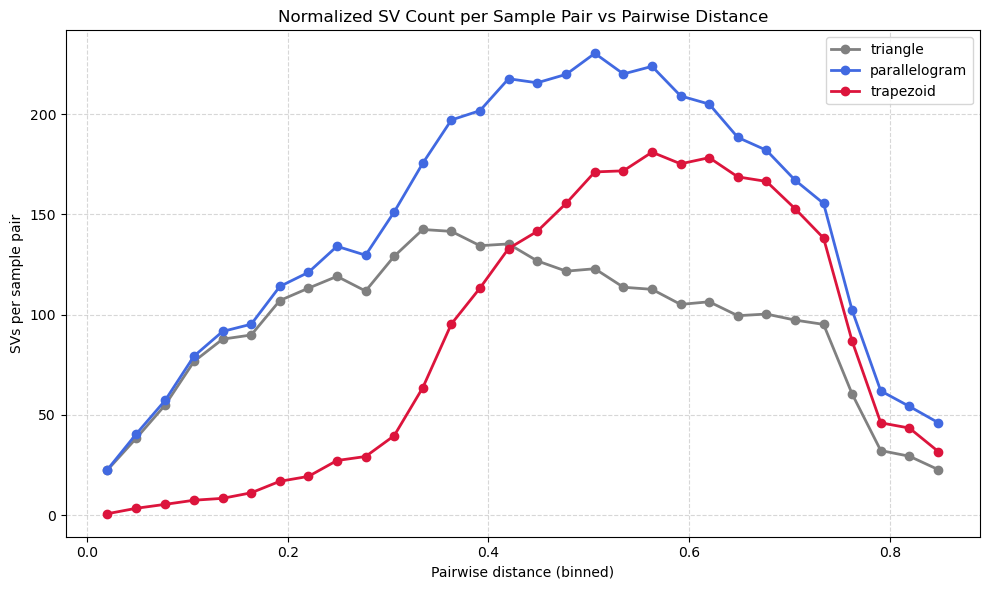

In [17]:
# Conditions
from matplotlib.ticker import ScalarFormatter

conditions = {
    "triangle":  (df_sv_sorted["diff"] == -1),
    "parallelogram": (df_sv_sorted["diff"] < 0.1),
    "trapezoid": (df_sv_sorted["diff"] > 0.1)
}

colors = {
    "triangle": "gray",
    "parallelogram": "royalblue",
    "trapezoid": "crimson"
}

# -------------------------------------------------------
# 1. Define global distance bins
# -------------------------------------------------------
n_bins = 30
df_sv_sorted["dist_bin"] = pd.cut(df_sv_sorted["pairwise_dist"], bins=n_bins)

# -------------------------------------------------------
# 2. Count how many sample pairs occur in each bin
# -------------------------------------------------------
# One row per sample-pair for correct weighting
pairs = df_sv_sorted.groupby("sample_pair", as_index=False)["pairwise_dist"].first()
pairs["dist_bin"] = pd.cut(pairs["pairwise_dist"], bins=df_sv_sorted["dist_bin"].cat.categories)

sample_pair_counts = (
    pairs.groupby("dist_bin")
         .size()
         .reset_index(name="num_pairs_in_bin")
)

# -------------------------------------------------------
# 3. Count SVs per bin per condition
# -------------------------------------------------------
plot_df = []

for label, mask in conditions.items():

    subset = df_sv_sorted[mask]

    sv_counts = (
        subset.groupby("dist_bin")
              .size()
              .reset_index(name="sv_count")
    )

    # merge in the number of sample pairs in that bin
    merged = sv_counts.merge(sample_pair_counts, on="dist_bin", how="left")

    # Normalize:
    merged["svs_per_pair"] = merged["sv_count"] / merged["num_pairs_in_bin"]

    merged["condition"] = label
    plot_df.append(merged)

plot_df = pd.concat(plot_df, ignore_index=True)

# -------------------------------------------------------
# 4. Plot normalized SV counts
# -------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

for label in conditions.keys():
    df_c = plot_df[plot_df["condition"] == label].copy()

    # Convert bins to midpoints for plotting
    df_c["midpoint"] = df_c["dist_bin"].apply(lambda x: x.mid)

    ax.plot(
        df_c["midpoint"],
        df_c["svs_per_pair"],
        marker="o",
        color=colors[label],
        linewidth=2,
        label=label
    )

ax.set_xlabel("Pairwise distance (binned)")
ax.set_ylabel("SVs per sample pair")
ax.set_title("Normalized SV Count per Sample Pair vs Pairwise Distance")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()


yfmt = ScalarFormatter(useOffset=False)
yfmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(yfmt)
plt.tight_layout()
plt.show()

/data/tmp/ipykernel_872037/3779626553.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_872037/3779626553.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_872037/3779626553.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


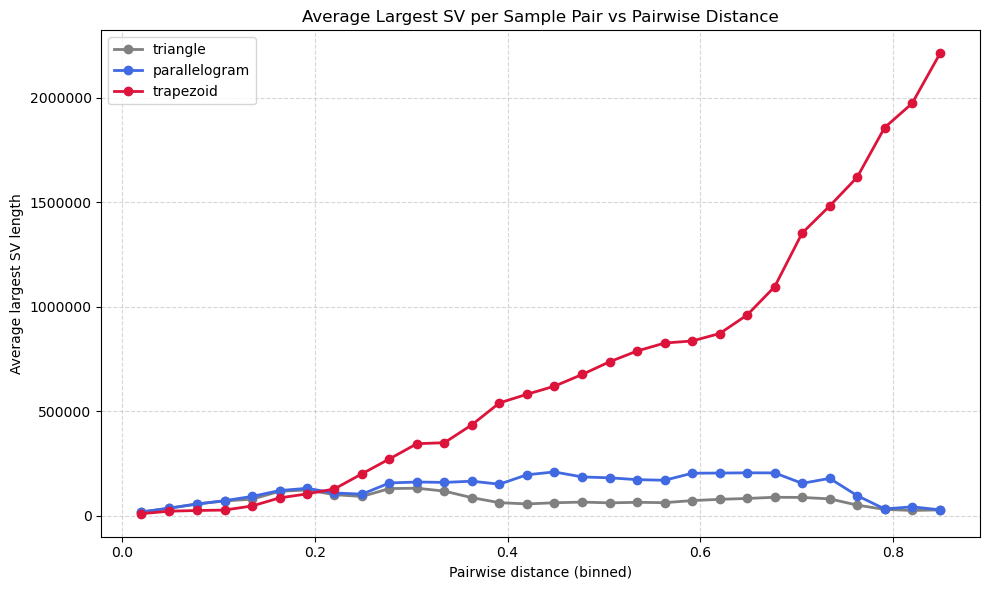

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Ensure sample_pair is defined
df_sv_sorted["sample_pair"] = df_sv_sorted["sample1"] + "_" + df_sv_sorted["sample2"]


conditions = {
    "triangle":  (df_sv_sorted["diff"] == -1),
    "parallelogram": (df_sv_sorted["diff"] < 0.1),
    "trapezoid": (df_sv_sorted["diff"] > 0.1)
}

colors = {
    "triangle": "gray",
    "parallelogram": "royalblue",
    "trapezoid": "crimson"
}


# -------------------------------------------------------
# 1. Define bins over pairwise distance
# -------------------------------------------------------
n_bins = 30
bins = pd.cut(df_sv_sorted["pairwise_dist"], bins=n_bins)


# -------------------------------------------------------
# 2. Function: largest SV per sample pair
# -------------------------------------------------------
def get_largest_sv(subset):
    largest = (
        subset.sort_values("length", ascending=False)
              .groupby("sample_pair", as_index=False)
              .first()   # row with maximum 'length'
    )
    return largest


# -------------------------------------------------------
# 3. Compute mean largest-SV per bin per condition
# -------------------------------------------------------
plot_df = []

for label, mask in conditions.items():
    subset = df_sv_sorted[mask].copy()

    # collapse to largest SV per sample_pair
    largest = get_largest_sv(subset)

    # bin distances for these pairs
    largest["dist_bin"] = pd.cut(largest["pairwise_dist"], bins=bins.cat.categories)

    # compute mean length per bin
    stats = (
        largest.groupby("dist_bin")["length"]
               .mean()
               .reset_index(name="mean_length")
    )
    stats["condition"] = label
    plot_df.append(stats)

plot_df = pd.concat(plot_df, ignore_index=True)


# -------------------------------------------------------
# 4. Plot
# -------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

for label in conditions.keys():
    df_c = plot_df[plot_df["condition"] == label].copy()

    # x-axis = midpoint of each distance bin
    df_c["midpoint"] = df_c["dist_bin"].apply(lambda x: x.mid)

    ax.plot(
        df_c["midpoint"],
        df_c["mean_length"],
        marker="o",
        color=colors[label],
        linewidth=2,
        label=label
    )

ax.set_xlabel("Pairwise distance (binned)")
ax.set_ylabel("Average largest SV length")
ax.set_title("Average Largest SV per Sample Pair vs Pairwise Distance")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

yfmt = ScalarFormatter(useOffset=False)
yfmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(yfmt)
plt.tight_layout()
plt.show()
